# Rossmann销售额预测

## 1. 项目背景

Rossmann是欧洲的一家连锁药店，2015年Rossmann和Kaggle合作，举办数据分析比赛，参赛选手根据Rossman旗下的1115家药店每日的销售额和药店的属性（是否促销、竞争对手情况、节假日）来预测未来一段时间的销售额。从项目背景上看，该项目属于机器学习中的监督式学习，而且属于回归问题。  

## 2. 加载数据集
从数据集的下载网址：https://www.kaggle.com/c/rossmann-store-sales/data 下载了3个文件，分别是"**train.csv**"、"**test.csv**"和"**store.csv**"。首先需要对该数据集进行EAD分析。

In [1]:
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
# import seaborn as sns
import random
import time
%matplotlib inline

# 显示全部的列
pd.set_option('display.max_columns', None)

### 2.1 加载数据 train.csv

In [2]:
df_train = pd.read_csv('train.csv')

C:\Users\wolfman\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# 查看df_train的基本信息
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [4]:
# df_train的调查
df_train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [5]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


通过上述调查可知，train.csv数据集中有1017209条数据，共有9个特征，分别是'Store'，'DayofWeek'，'Date'，'Sales'，'Customers'，'Open'，'Promo'，
'StateHoliday'和'SchoolHoliday'。train.csv数据集中没有缺失值。除了'Date'和'StateHoliday'是'object'类型以外，其余特征的类型都是整型。

In [6]:
# 查看Date的特征
type(df_train['Date'][0])

str

In [7]:
# 查看SateHoliday的特征,根据Kaggle数据集文档介绍，类型有0,a,b,c
set(df_train['StateHoliday'])

{0L, '0', 'a', 'b', 'c'}

通过上面的分析，说明pandas在读取日期数据时，把日期数据转换为字符串类型。为了能在后面方便地操作时间信息，我需要把'Date'特征转换为'datetime64'类型。另外，'StateHoliday'应该4种类型，而pandas把‘StateHoliday’分为了5种特征{0L, '0', 'a', 'b', 'c'},其中0L是长整型数，所以需要把'StateHoliday'的数据格式转为字符串。

In [8]:
df_train['Date'] = df_train['Date'].astype('datetime64')
df_train['StateHoliday'] = df_train['StateHoliday'].astype('str')

In [9]:
set(df_train['StateHoliday'])

{'0', 'a', 'b', 'c'}

In [10]:
(df_train['Date'].min(),df_train['Date'].max())

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

该数据集的时间跨度为2013-01-01到2015-07-31

### 2.2 加载数据集test.csv

In [11]:
# 加载数据集'test.csv'
df_test = pd.read_csv('test.csv')
# df_store = pd.read_csv('store.csv')

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [13]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [14]:
(df_test['Date'].min(),df_test['Date'].max())

('2015-08-01', '2015-09-17')

通过上述分析可知，test.csv的时间范围（'2015-08-01'~ '2015-09-17'）在train.csv时间范围（'2013-01-01', '2015-07-31'）之后，测试集test.csv除了没有'Sales'特征,增加了'Id'特征以外，其余的特征与train.csv一致。这是因为Kaggle公司在测试集上不提供'Sales'特征，而是让参赛选手在测试集上预测结果然后提交到Kaggle服务器上进行评分。为了能在本地电脑上进行预测和验证，我准备暂时不考虑该测试集'test.csv'，用训练集'train.csv'的一部分作为测试集来预测和验证。

### 2.3 加载数据集'store.csv'

In [15]:
df_store = pd.read_csv('store.csv')

In [16]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [17]:
# 查看df_store的缺失值
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [18]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [19]:
# 查看CompetionDistance的缺失值
df_store[df_store.isnull()['CompetitionDistance']]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


可以看到CompetionDistance的缺失值只有3行，而且CompetitionOpenSinceMonth，CompetitionOpenSinceYear，的信息均没有，有两种可能造成该行没有信息：（1）周围没有竞争对手，所以没填；（2）统计漏洞；   
我按第一种情况考虑,（参考了知乎：https://www.zhihu.com/question/26639110） 缺失值的处理的贴子），取该列最大值进行填充，意味着，竞争对手离我很远，影响可以忽略不计。

In [20]:
df_store['CompetitionDistance'] = df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].max())

In [21]:
# 查看填充情况
df_store.iloc[[290,621,878],:]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,75860.0,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,75860.0,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,75860.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


CompetitionOpenSinceMonth 和 CompetitionOpenSinceYear 的缺失值均有354个，需要调查一下是否缺失情况“重叠”

In [22]:
df_store[pd.isnull(df_store['CompetitionOpenSinceMonth'])].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 11 to 1114
Data columns (total 10 columns):
Store                        354 non-null int64
StoreType                    354 non-null object
Assortment                   354 non-null object
CompetitionDistance          354 non-null float64
CompetitionOpenSinceMonth    0 non-null float64
CompetitionOpenSinceYear     0 non-null float64
Promo2                       354 non-null int64
Promo2SinceWeek              206 non-null float64
Promo2SinceYear              206 non-null float64
PromoInterval                206 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 30.4+ KB


通过上面计算结果，可知CompetitionOpenSinceMonth	CompetitionOpenSinceYear，缺失值缺失重叠，缺少的数量有354个占该数据集1/3左右，用均值替代似乎不太合理，考虑到后面模型主要是用决策树回归模型，我决定将缺失值设置为-1，树模型在分叉时可以按负值和正值分割数据，负值代表缺失值，然后树模型再继续分割。

In [23]:
df_store['CompetitionOpenSinceMonth'] = df_store['CompetitionOpenSinceMonth'].fillna(-1)
df_store['CompetitionOpenSinceYear'] = df_store['CompetitionOpenSinceYear'].fillna(-1)
df_store[(df_store['CompetitionOpenSinceMonth'] == -1) & (df_store['CompetitionOpenSinceYear'] == -1)].shape

(354, 10)

store数据集中的Promo2代表门店是否长期参加促销活动，0代表门店不参加，1代表参加，首先先调查由多少个店参与长期促销

In [24]:
# 调查多少个门店长期参加促销
df_store['Promo2'].sum()

571

In [25]:
# 调查参加促销的门店的缺失值
df_store[df_store['Promo2'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571 entries, 1 to 1114
Data columns (total 10 columns):
Store                        571 non-null int64
StoreType                    571 non-null object
Assortment                   571 non-null object
CompetitionDistance          571 non-null float64
CompetitionOpenSinceMonth    571 non-null float64
CompetitionOpenSinceYear     571 non-null float64
Promo2                       571 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 49.1+ KB


In [26]:
# 调查不参加促销的门店的缺失值
df_store[df_store['Promo2'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544 entries, 0 to 1113
Data columns (total 10 columns):
Store                        544 non-null int64
StoreType                    544 non-null object
Assortment                   544 non-null object
CompetitionDistance          544 non-null float64
CompetitionOpenSinceMonth    544 non-null float64
CompetitionOpenSinceYear     544 non-null float64
Promo2                       544 non-null int64
Promo2SinceWeek              0 non-null float64
Promo2SinceYear              0 non-null float64
PromoInterval                0 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 46.8+ KB


通过上面的分析结果说明，参加促销门店的'Promo2SinceWeek','Promo2SinceYear','PromoInterval'特征均有数据；不参加促销门店的上述3个特征均没有记录。与上面处理方法类似，'Promo2SinceWeek','Promo2SinceYear'的缺失值设置为-1。

In [27]:
df_store['Promo2SinceWeek'] = df_store['Promo2SinceWeek'].fillna(-1)
df_store['Promo2SinceYear'] = df_store['Promo2SinceYear'].fillna(-1)

df_store['CompetitionDistance'] = df_store['CompetitionDistance'].astype('int')
df_store['CompetitionOpenSinceMonth'] = df_store['CompetitionOpenSinceMonth'].astype('int')
df_store['CompetitionOpenSinceYear'] = df_store['CompetitionOpenSinceYear'].astype('int')
df_store['Promo2SinceWeek'] = df_store['Promo2SinceWeek'].astype('int')
df_store['Promo2SinceYear'] = df_store['Promo2SinceYear'].astype('int')

'PromoInterval'特征除缺失值外，每行的数据有4个月份，类型是字符串，考虑到该特征有缺失值，我将该特征转换成12个特征，对应12个月。例如：某一行数据为 “Jan,Apr,Jul,Oct”，那么新的特征PromoInterval_Jan,PromoInterval_Apr,PromoInterval_Jul,PromoInterval_Oct对应的数据为1，其余为0，如果是缺失值，那么这一行都为0，过程见下：

In [28]:
# 创建一个1115行12列的np矩阵
df_new = np.zeros((df_store.shape[0],12),dtype = np.int)

# 对应的月份映射到第n列
month_to_column = {
            'Jan' : 0,
            'Feb' : 1,
            'Mar' : 2,
            'Apr' : 3,
            'May' : 4,
            'Jun' : 5,
            'Jul' : 6,
            'Aug' : 7,
            'Sept' : 8, 
            'Oct' : 9,
            'Nov' : 10,
            'Dec' : 11}
month_list = [ 'Jan','Feb','Mar','Apr','May','Jun','Jul', 'Aug','Sept','Oct','Nov','Dec']

# 定义一个转化"字符串" -> "字符串向量" -> 映射到上面定义的矩阵的相应位置
def append_month_int(row_value,n):
    if row_value is np.nan:
        return
    else:
        month_list =  row_value.split(',')
        for month in month_list:
            df_new[n][month_to_column[month]]= 1


for n,row_value in enumerate(df_store['PromoInterval']):
    append_month_int(row_value, n)

In [29]:
# column的名字
new_columns = []
for month in month_list:
    new_columns.append('PromoInterval_'+ month)

In [30]:
# 创建新的dataframe
df_new = pd.DataFrame(df_new,columns = new_columns)
df_new.head()

,PromoInterval_Jan,PromoInterval_Feb,PromoInterval_Mar,PromoInterval_Apr,PromoInterval_May,PromoInterval_Jun,PromoInterval_Jul,PromoInterval_Aug,PromoInterval_Sept,PromoInterval_Oct,PromoInterval_Nov,PromoInterval_Dec
0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,1,0,0,1,0,0
2,1,0,0,1,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# 将df_new与df_store合并
df_store = df_store.join(df_new)
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,PromoInterval_Jan,PromoInterval_Feb,PromoInterval_Mar,PromoInterval_Apr,PromoInterval_May,PromoInterval_Jun,PromoInterval_Jul,PromoInterval_Aug,PromoInterval_Sept,PromoInterval_Oct,PromoInterval_Nov,PromoInterval_Dec
0,1,c,a,1270,9,2008,0,-1,-1,NaN,0,0,0,0,0,0,0,0,0,0,0,0
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",1,0,0,1,0,0,1,0,0,1,0,0
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",1,0,0,1,0,0,1,0,0,1,0,0
3,4,c,c,620,9,2009,0,-1,-1,NaN,0,0,0,0,0,0,0,0,0,0,0,0
4,5,a,a,29910,4,2015,0,-1,-1,NaN,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
# 删除PromoInterval这一列：
df_store= df_store.drop('PromoInterval', 1)

### 2.4 合并数据集

In [33]:
# 合并数据集
df = pd.merge(df_train, df_store, how='left', on=['Store'])

In [34]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_Jan,PromoInterval_Feb,PromoInterval_Mar,PromoInterval_Apr,PromoInterval_May,PromoInterval_Jun,PromoInterval_Jul,PromoInterval_Aug,PromoInterval_Sept,PromoInterval_Oct,PromoInterval_Nov,PromoInterval_Dec
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270,9,2008,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570,11,2007,1,13,2010,1,0,0,1,0,0,1,0,0,1,0,0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130,12,2006,1,14,2011,1,0,0,1,0,0,1,0,0,1,0,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620,9,2009,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910,4,2015,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
df.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval_Jan            0
PromoInterval_Feb            0
PromoInterval_Mar            0
PromoInterval_Apr            0
PromoInterval_May            0
PromoInterval_Jun            0
PromoInterval_Jul            0
PromoInterval_Aug            0
PromoInterval_Sept           0
PromoInterval_Oct            0
PromoInterval_Nov            0
PromoInterval_Dec            0
dtype: int64

通过上面分析可知，数据集df已没有缺失值

### 2.5 分配测试集和训练集

由于是预测未来销售数据，而且数据集是时间序列，将数据集最后两个月的数据定义为测试集，其余数据为训练集。

In [36]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_Jan,PromoInterval_Feb,PromoInterval_Mar,PromoInterval_Apr,PromoInterval_May,PromoInterval_Jun,PromoInterval_Jul,PromoInterval_Aug,PromoInterval_Sept,PromoInterval_Oct,PromoInterval_Nov,PromoInterval_Dec
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270,9,2008,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570,11,2007,1,13,2010,1,0,0,1,0,0,1,0,0,1,0,0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130,12,2006,1,14,2011,1,0,0,1,0,0,1,0,0,1,0,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620,9,2009,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910,4,2015,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# 增加测试集标签，测试集为1，训练集为0
df.loc[(df['Date'] >= pd.to_datetime('2015-06-01',format='%Y-%m-%d')),'Test_set'] = 1
df['Test_set'] = df['Test_set'].fillna(0)
df['Test_set'] = df['Test_set'].astype('int')
df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_Jan,PromoInterval_Feb,PromoInterval_Mar,PromoInterval_Apr,PromoInterval_May,PromoInterval_Jun,PromoInterval_Jul,PromoInterval_Aug,PromoInterval_Sept,PromoInterval_Oct,PromoInterval_Nov,PromoInterval_Dec,Test_set
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900,6,2014,1,31,2013,1,0,0,1,0,0,1,0,0,1,0,0,0
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880,4,2006,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260,-1,-1,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870,-1,-1,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350,-1,-1,1,22,2012,0,0,1,0,0,1,0,0,1,0,0,1,0


## 3 探索数据集

### 3.1　一维数据分析

#### 3.1.1 Sales的分布情况

In [38]:
# Sales的数据分布
sales = df[df['Open'] == 1]['Sales']
sales.describe()

count    844392.000000
mean       6955.514291
std        3104.214680
min           0.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64

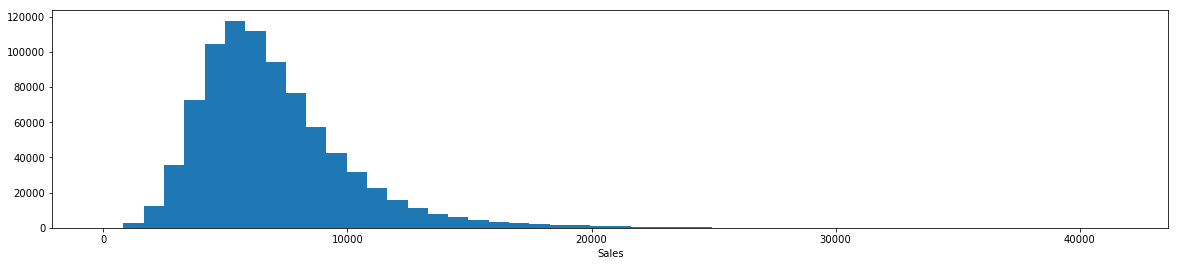

In [39]:
# 特征Sales的直方图
plt.rcParams["figure.figsize"] = [20,4]
plt.hist(sales, bins=50)
plt.xlabel('Sales')

通过上图可知，如果不考虑销售额为0的情况，每日销售额为正偏斜分布。均值为6956，中位数为6369。

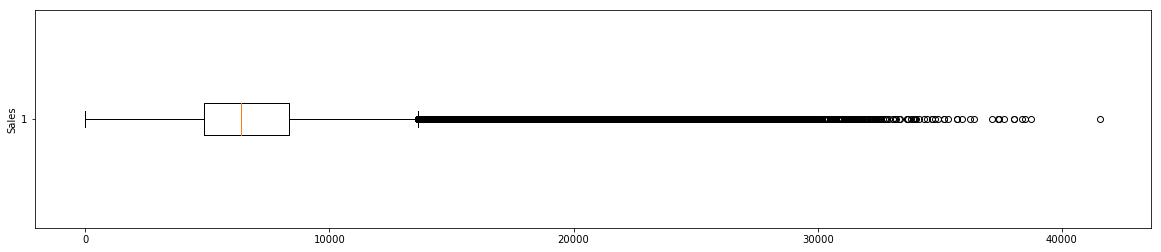

In [40]:
plt.rcParams["figure.figsize"] = [20,4]
plt.boxplot(sales,vert=False)
plt.ylabel('Sales')

In [41]:
# 统计Sales特征异常值的数量
q75, q25 = np.percentile(sales, [75 ,25])
iqr = q75 - q25
df[df['Sales']>(1.5*iqr+q75)].shape[0]

30769

销售额的异常值有30769个，**但是可能有的店销量很大，所以在总体数据集中找异常值没有意义，需要分店考虑。后面会对Sales异常值进行清洗。**

#### 3.1.2 Customes 的分布情况

In [42]:
customers = df[df['Open'] == 1]['Customers']
customers.describe()

count    844392.000000
mean        762.728395
std         401.227674
min           0.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        7388.000000
Name: Customers, dtype: float64

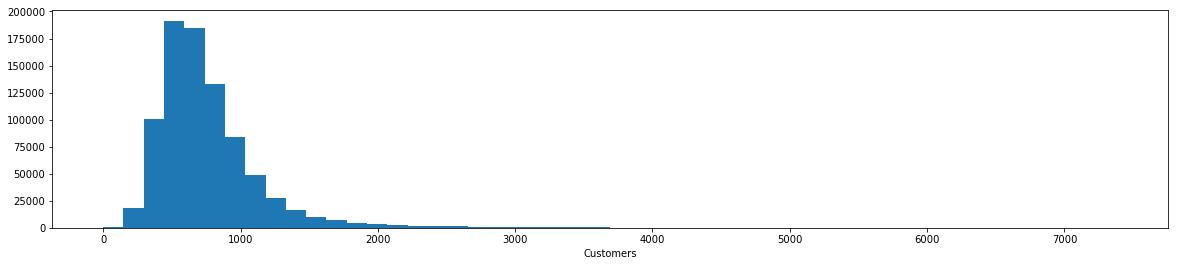

In [43]:
# 特征Customers的直方图
plt.rcParams["figure.figsize"] = [20,4]
plt.hist(customers, bins=50)
plt.xlabel('Customers')

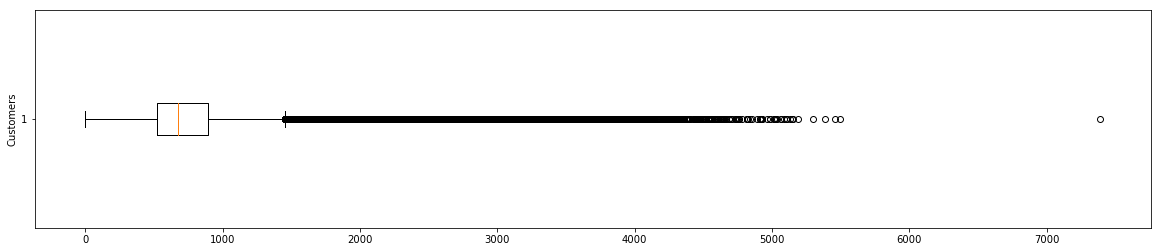

In [44]:
plt.rcParams["figure.figsize"] = [20,4]
plt.boxplot(customers,vert=False)
plt.ylabel('Customers')

在图中看到有1个点的位置明显偏离其它值，下面做一些简单的调查。

In [45]:
df[df['Customers']>6000]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_Jan,PromoInterval_Feb,PromoInterval_Mar,PromoInterval_Apr,PromoInterval_May,PromoInterval_Jun,PromoInterval_Jul,PromoInterval_Aug,PromoInterval_Sept,PromoInterval_Oct,PromoInterval_Nov,PromoInterval_Dec,Test_set
993496,817,2,2013-01-22,27190,7388,1,1,0,0,a,a,140,3,2006,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0


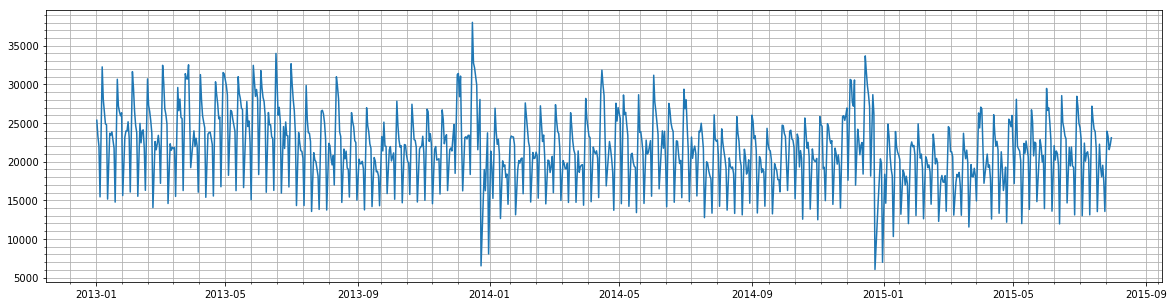

In [46]:
# 画出817号门店销售额曲线
plt.rcParams["figure.figsize"] = [20,5]
X1 = df.loc[(df['Store'] == 817) & (df['Open'] == 1)]['Date']
y1 = df.loc[(df['Store'] == 817) & (df['Open'] == 1)]['Sales']
plt.plot(X1, y1, '-')
plt.minorticks_on()
plt.grid(True, which='both')

顾客在2013年1月22日，有7388人次光顾了编号817的药店，但是销售额并没有明显的增加。可能是统计错误。

#### 3.1.3 店铺种类统计

In [47]:
storetype_count = df_store.groupby('StoreType').size()
storetype_count

StoreType
a    602
b     17
c    148
d    348
dtype: int64

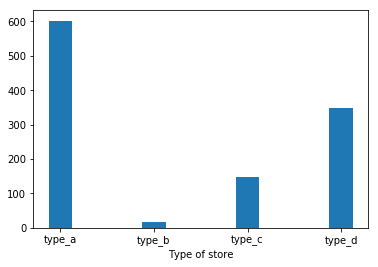

In [48]:
plt.rcParams["figure.figsize"] = [6,4]
plt.bar(left = (0.2,1,1.8,2.6),height = storetype_count,width = 0.2,align="center")
plt.xticks((0.2,1,1.8,2.6),('type_a','type_b','type_c','type_d'))
plt.xlabel('Type of store')

通过上图可知，a类门店的数目最多，有602个，b类门店的数量最少，只有17个。

#### 3.1.4 门店供货范围等级及各自的数量

In [49]:
store_assortment_count = df_store.groupby('Assortment').size()
store_assortment_count

Assortment
a    593
b      9
c    513
dtype: int64

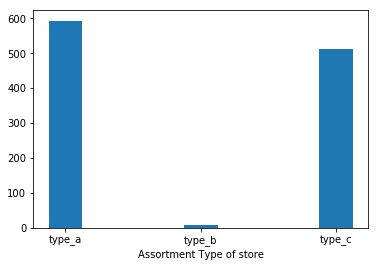

In [50]:
plt.rcParams["figure.figsize"] = [6,4]
plt.bar(left = (0.2,1,1.8),height = store_assortment_count, width = 0.2,align="center")
plt.xticks((0.2,1,1.8),('type_a','type_b','type_c'))
plt.xlabel('Assortment Type of store')

门店的供货范围有3个等级，a属于基础供货范围、b的供货范围在a的基础上扩充一部分、c的供货范围最全。奇怪的是，b类的店铺的数量只有9个。

#### 3.1.5竞争对手的距离

In [51]:
df['CompetitionDistance'].describe()

count    1.017209e+06
mean     5.613013e+03
std      8.498338e+03
min      2.000000e+01
25%      7.100000e+02
50%      2.330000e+03
75%      6.910000e+03
max      7.586000e+04
Name: CompetitionDistance, dtype: float64

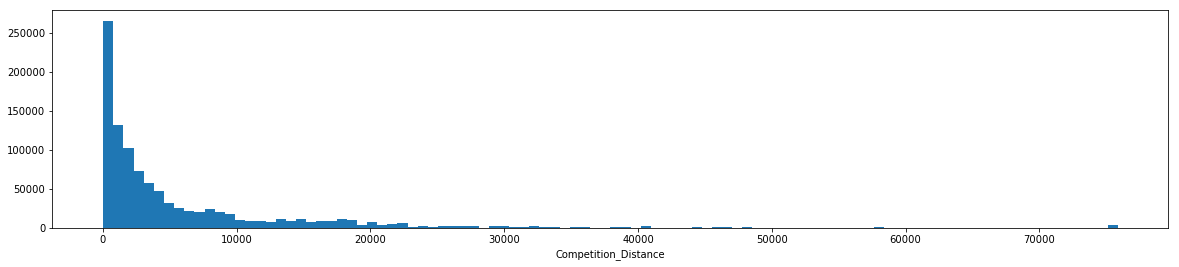

In [52]:
plt.rcParams["figure.figsize"] = [20,4]
plt.hist(df['CompetitionDistance'],bins=100)
plt.xlabel('Competition_Distance')

分布图呈现正偏斜分布

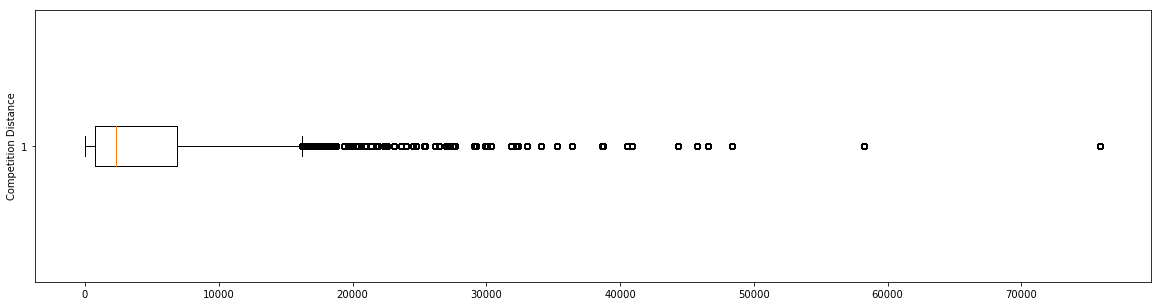

In [53]:
plt.rcParams["figure.figsize"] = [20,5]
plt.boxplot([df['CompetitionDistance']],vert=False)
plt.ylabel('Competition Distance')

上图说明大部店铺的竞争对手都在1公里以内, Rossmann的统计范围大到70公里以外的竞争对手。

#### 3.1.6 每周的门店的营业情况

In [54]:
# 只统计开店时的数据
week_count = df[df['Open'] == 1].groupby('DayOfWeek').size()
week_count

DayOfWeek
1    137560
2    143961
3    141936
4    134644
5    138640
6    144058
7      3593
dtype: int64

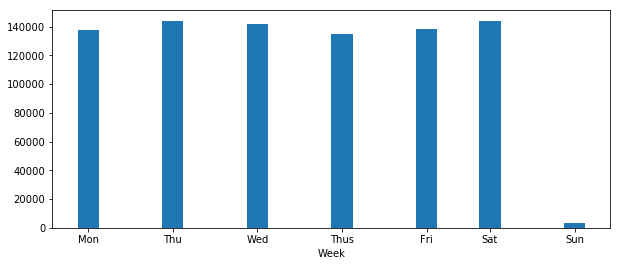

In [55]:
plt.rcParams["figure.figsize"] = [10,4]
plt.bar(left = (0.2, 1.0, 1.8, 2.6, 3.4, 4.0, 4.8),height = week_count, width = 0.2, align="center")
plt.xticks((0.2, 1.0, 1.8, 2.6, 3.4, 4.0, 4.8),('Mon','Thu','Wed','Thus','Fri','Sat','Sun'))
plt.xlabel('Week')

上图我过滤了关店时的数据，发现星期日“开店记录”很少，说明大部分店铺在周日都休息。周一到周六的开店数据量基本相同。

### 3.2 多维数据分析

### 3.2.1 每种门店的平均销售额
下面来调查每种门店的每天的平均销售额。有两个特征"Storetype"和"Assortment"分别考虑。

** - 针对‘StoreType’特征**

In [56]:
storetype_sales_mean = df[df['Open'] == 1].groupby('StoreType').mean()['Sales']
storetype_sales_mean

StoreType
a     6925.167661
b    10231.407505
c     6932.512755
d     6822.141881
Name: Sales, dtype: float64

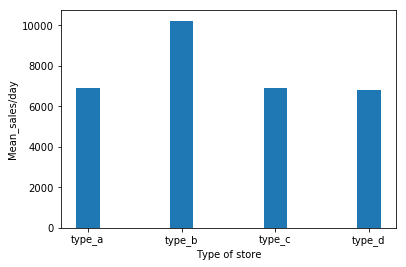

In [57]:
plt.rcParams["figure.figsize"] = [6,4]
plt.bar(left = (0.2,1,1.8,2.6),height = storetype_sales_mean,width = 0.2,align="center")
plt.xticks((0.2,1,1.8,2.6),('type_a','type_b','type_c','type_d'))
plt.xlabel('Type of store')
plt.ylabel('Mean_sales/day')

上图说明b类商店每天的平均销售额最高，a类、b类、c类商店的销售额几乎相同。

**- 针对‘Assortment’特征**

In [58]:
storeAssortment_sales_mean = df[df['Open'] == 1].groupby('Assortment').mean()['Sales']
storeAssortment_sales_mean

Assortment
a    6621.017039
b    8639.346322
c    7300.526339
Name: Sales, dtype: float64

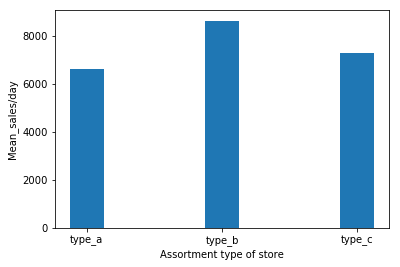

In [59]:
plt.rcParams["figure.figsize"] = [6,4]
plt.bar(left = (0.2,1,1.8),height = storeAssortment_sales_mean,width = 0.2,align="center")
plt.xticks((0.2,1,1.8),('type_a','type_b','type_c'))
plt.xlabel('Assortment type of store')
plt.ylabel('Mean_sales/day')

上图说明Assortment类型为b的每天平均销量最高，但根据上面3.1.4节分析可知，这样的门店的数量只有9个，Rossmann的管理层是否可以考虑一下调整门店的销售范围呢？

### 3.2.2 销售额和客流量关系

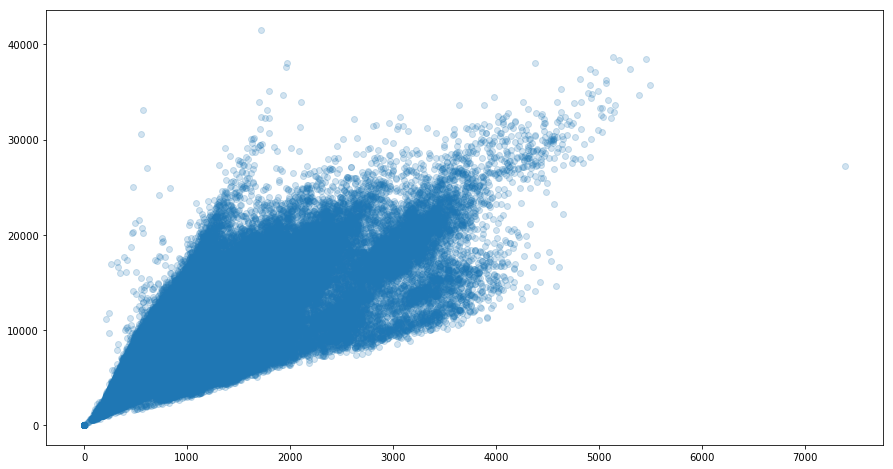

In [60]:
plt.rcParams["figure.figsize"] = [15,8]

x1 = df[df['Open']==1]['Customers']
y1 = df[df['Open']==1]['Sales']

plt.scatter(x1,y1,alpha=0.2)

上图符合经验，即客流越多销售额越高。而且发现了图最右侧的点明显是异常值（3.12节已经讨论过）。**但是，"Customers"不能作为特征直接用来预测销售额，因为未来时期我们是不知道客流量多少的。**要使用Customers的信息可以构造新的变量，例如在训练集上计算出“单店平均每日客流量”作为特征来使用。

### 3.2.3 时间-销售额的关系
根据经验，各店的销售额是随时间变化的，但是由于门店有1115个，每个都列出观察不太现实，这里随机选取5个店来观察销售额随时间变化的曲线。

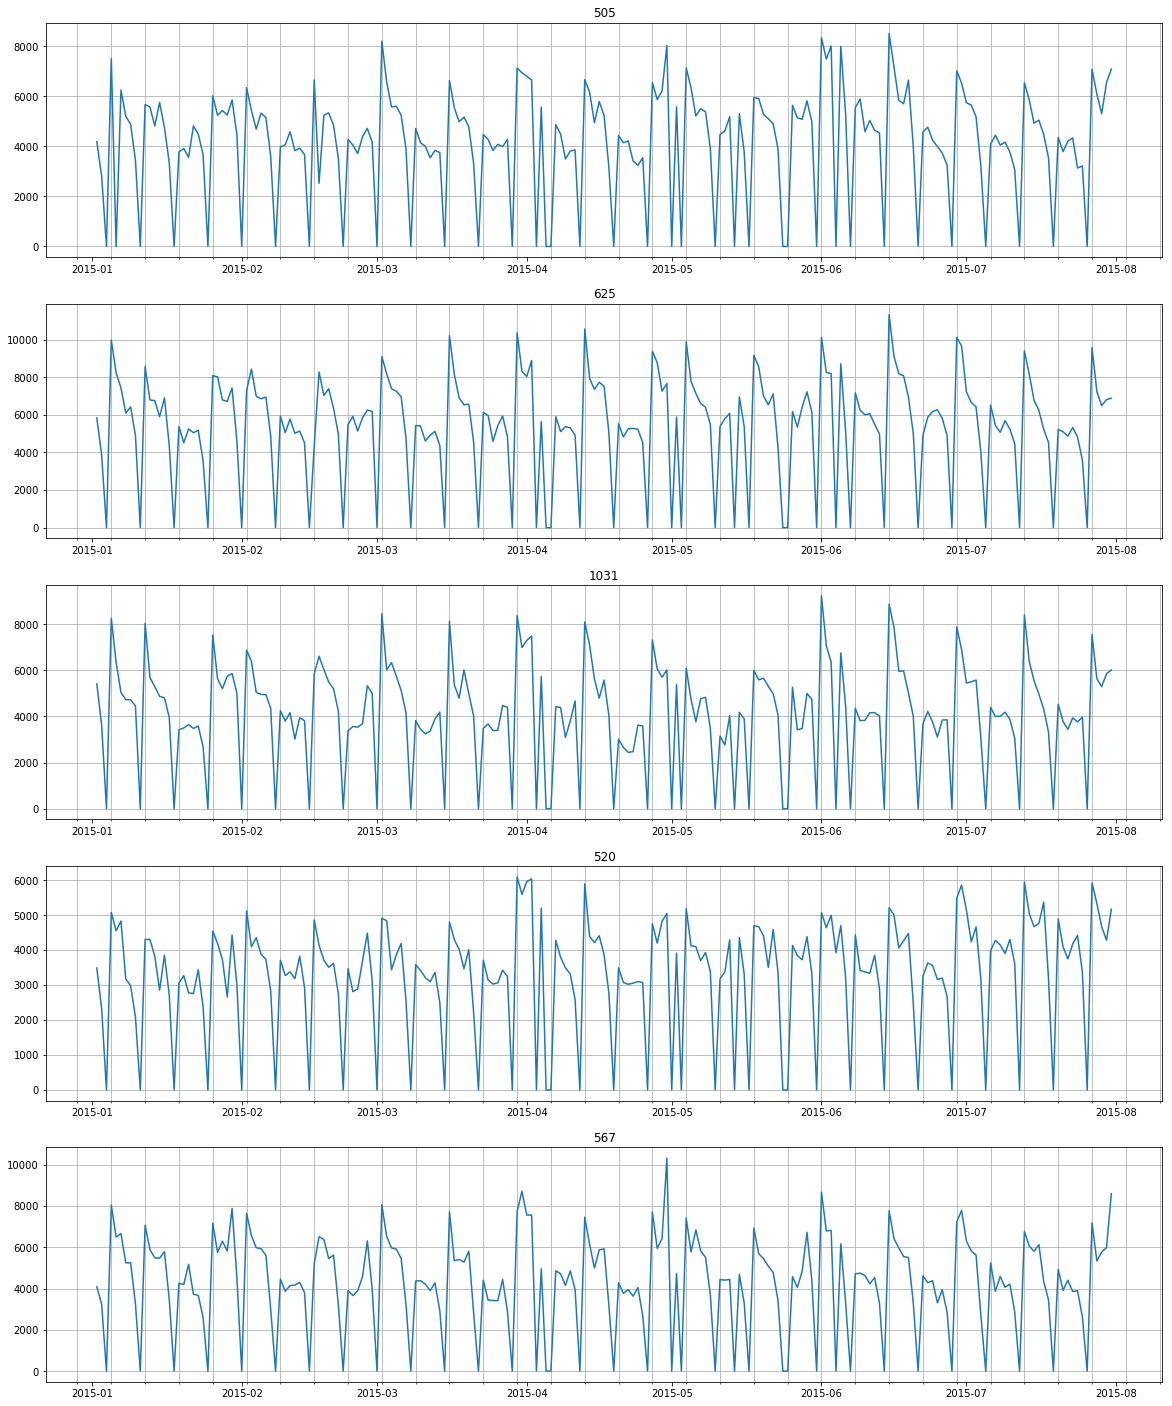

In [61]:
import random
import matplotlib.dates as dates
random.seed(11)
list_stores_to_check = random.sample(df['Store'].unique(),5)

plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1
for i in list_stores_to_check:
    stor = i

    # 由于显示范围的问题，只列出2015-01-01以后的数据
    X1 = df.loc[(df['Store'] == stor)&(df['Date']> pd.to_datetime('2015-01-01'))]['Date']
    y1 = df.loc[(df['Store'] == stor)&(df['Date']> pd.to_datetime('2015-01-01'))]['Sales']
    
    ax = plt.subplot(len(list_stores_to_check),1,j)
    plt.plot(X1, y1, '-')
    # X坐标每条小刻度代表周一，一周一个格
    ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),interval=1))
    ax.xaxis.grid(True, which="minor")
    ax.yaxis.grid()                
    plt.title(i)
    j += 1

通过上面这10个门店的观察可知，销售额随时间明显呈现周期性变化，即波形的上下摆动很有规律。通过上述分析可知，如果让机器去预测销售额，时间是非常重要的特征，但是如果简单把‘Date’参数传给计算机，显然计算机做不到预测，因为训练集的时间和预测集的时间不重叠。但是我们可以构建新的特征，比如‘几号’，“第几周”，‘第几月’，‘第几年’等特征，预测集和训练集都有这样的特征，这样机器就可以根据时间特征进行预测了。   

另外，通过观察还发现部分销售额和时间的曲线，有“越阶”现象，比如885号门店（最后一张图），从2014年5月以后每日销售的均值明显高于2014年5月以前销售的均值。如果要预测未来销售额，显然最近一段时间的销售额数据比2年前的销售数据更具有参考意义。所以在后面的特征工程部分，我将构建最近1季度的均值作为新的特征，并使用该特征作为基准模型的参数。  

另外，值得注意的是，部分门店的销售额曲线存在“断档”现象，如上图的571号门店，这是由于门店重新装修导致。   

**为了能详细调查时间参数于销售额的关系，下面我们来构建新的时间特征。**

In [62]:
var_name = 'Date'

df[var_name + 'Day'] = pd.Index(df[var_name]).day     # 从每月的1日开始算，第几天
df[var_name + 'Week'] = pd.Index(df[var_name]).week    # 一年内的第几周，从1月1日开始算
df[var_name + 'Month'] = pd.Index(df[var_name]).month     # 第几月
df[var_name + 'Year'] = pd.Index(df[var_name]).year    # 哪一年
df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear    #一年内的第几天,从1月1日开始算

In [63]:
# 验证df['DateDayOfYear']应该有365个不同的数据
len(set(df['DateDayOfYear']))

365

**一周的平均销售额**

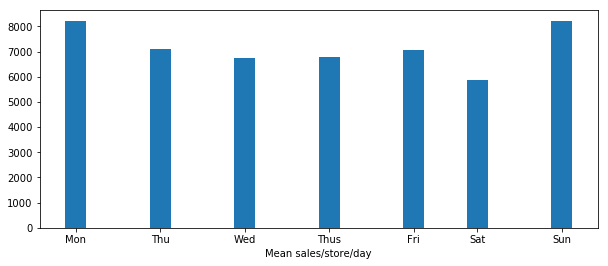

In [64]:
week_mean = df[df['Open'] == 1].groupby('DayOfWeek').mean()['Sales']
plt.rcParams["figure.figsize"] = [10,4]
plt.bar(left = (0.2, 1.0, 1.8, 2.6, 3.4, 4.0, 4.8),height = week_mean, width = 0.2, align="center")
plt.xticks((0.2, 1.0, 1.8, 2.6, 3.4, 4.0, 4.8),('Mon','Thu','Wed','Thus','Fri','Sat','Sun'))
plt.xlabel('Week')
plt.xlabel('Mean sales/store/day')

通过上图可知，即便周日大部分门店都停业，但是在周日开店的平均营业额是最高的，可能周日营业的门店本身地处繁华地段，销售火爆，周日赚钱的机会也不错过。周六开店的平均营业额最低，这个有点反常，可能是欧洲人周末休息；周一营业额偏高可能是周日门店大部分休息，购买力在周一释放了。

**一个月内的每日平均销售额**

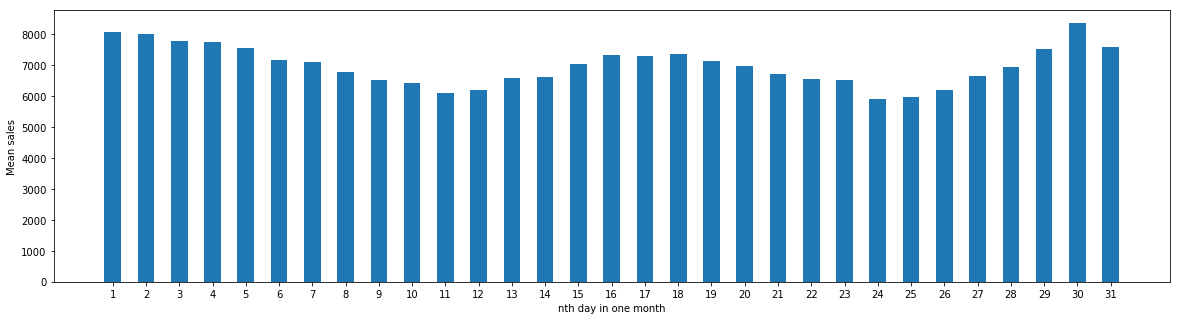

In [65]:
day_mean = df[df['Open'] == 1].groupby('DateDay').mean()['Sales']
plt.rcParams["figure.figsize"] = [20,5]
plt.bar(left = [i/10.0 for i in range(31)],height = day_mean, width = 0.05, align="center")
plt.xticks([i/10.0 for i in range(31)],range(1,32))
plt.xlabel('nth day in one month')
plt.ylabel('Mean sales')

通过上图可知，月初、月末和月中的平均销售额会高些。

**第n周的每日平均销售额**

In [66]:
week_mean = df[df['Open'] == 1].groupby('DateWeek').mean()['Sales']
len(week_mean)

52

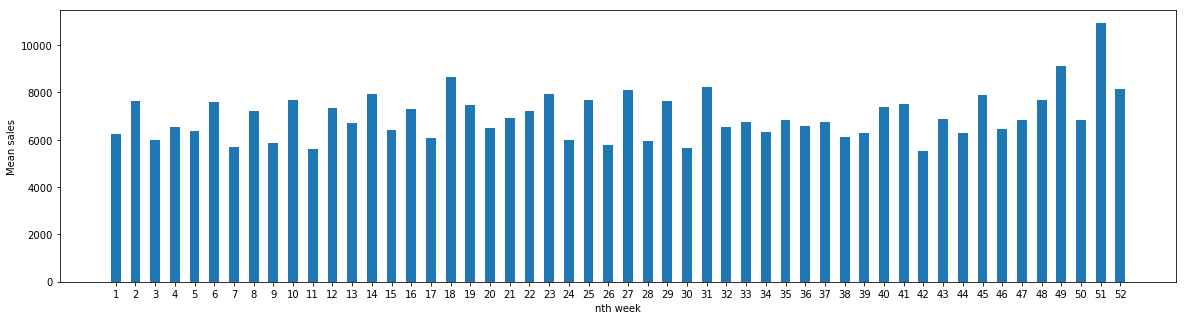

In [67]:
# 按周进行分组，然后求平均销售额，并画出曲线
week_mean = df[df['Open'] == 1].groupby('DateWeek').mean()['Sales']
plt.rcParams["figure.figsize"] = [20,5]
plt.bar(left = [i/10.0 for i in range(52)],height = week_mean, width = 0.05, align="center")
plt.xticks([i/10.0 for i in range(52)],range(1,53))
plt.xlabel('nth week')
plt.ylabel('Mean sales')

通过上图可看出，第51周内每日平均销售额最高，圣诞节前一周，是购物黄金时期。

**第n月内的每日平均销售额**

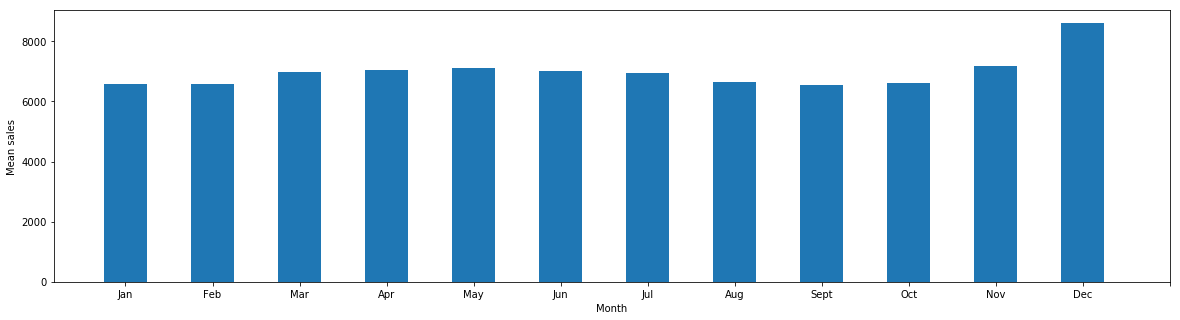

In [68]:
# 按月进行分组，然后求平均销售额，并画出曲线
month_mean = df[df['Open'] == 1].groupby('DateMonth').mean()['Sales']
plt.rcParams["figure.figsize"] = [20,5]
plt.bar(left = [i/10.0 for i in range(12)],height = month_mean, width = 0.05, align="center")
plt.xticks([i/10.0 for i in range(13)],month_list)
plt.xlabel('Month')
plt.ylabel('Mean sales')

通过上图可知，1月份，2月，9月是淡季，12月是销售旺季。

**第n年内每日平均销售额**

DateYear
2013    6814.392025
2014    7025.404201
2015    7088.126648
Name: Sales, dtype: float64


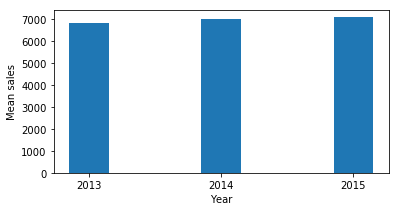

In [69]:
# 按年进行分组，然后求平均销售额，并画出曲线
year_mean = df[df['Open'] == 1].groupby('DateYear').mean()['Sales']
print year_mean
plt.rcParams["figure.figsize"] = [6,3]
plt.bar(left = [0,1,2],height = year_mean, width = 0.3, align="center")
plt.xticks([0,1,2],[2013,2014,2015])
plt.xlabel('Year')
plt.ylabel('Mean sales')

通过上图可知，每年的平均销售额逐年增加，但增加幅度不大，可能是通胀因素导致。

**一年内第n日平均销售额**

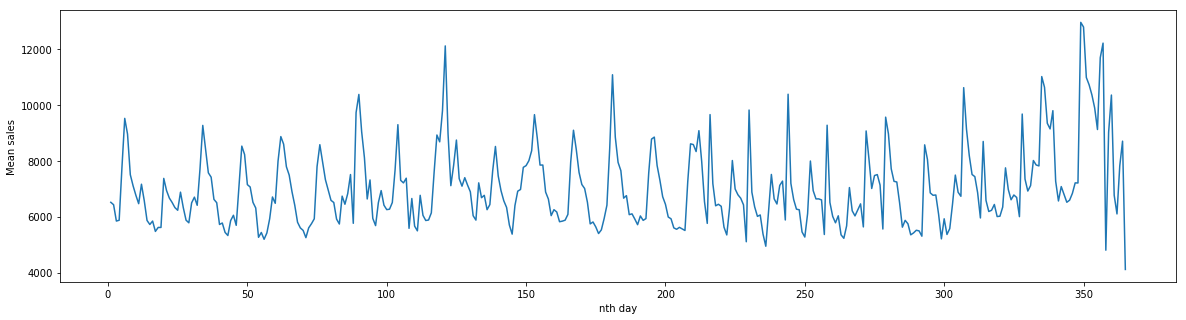

In [70]:
# 按年进行分组，然后求平均销售额，并画出曲线
dayofyear_mean = df[df['Open'] == 1].groupby('DateDayOfYear').mean()['Sales']
plt.rcParams["figure.figsize"] = [20,5]
plt.plot(range(1,len(dayofyear_mean)+1),dayofyear_mean, '-')
# plt.xticks([i/10.0 for i in range(52)],range(1,53))
plt.xlabel('nth day')
plt.ylabel('Mean sales')

In [71]:
dayofyear_mean.argmin()

365

In [72]:
dayofyear_mean.argmax()

349

In [73]:
dayofyear_mean.loc[100:150].argmax()

121

In [74]:
# 给出一年内的第几天得到日期的函数，参考：https://zhidao.baidu.com/question/458858645794105685.html
def out_date(day):
    # 2013,2014,2015年都不是润年，所以填哪年都一样
    fir_day = datetime.datetime(2013,1,1)
    zone = datetime.timedelta(days=day-1)
    return datetime.datetime.strftime(fir_day + zone, "%m-%d")

print out_date(365)
print out_date(349)
print out_date(121)

12-31
12-15
05-01


一年中销量最大的时间为第349天（12月15日），一年中销量最少的时间为第365天（12月31日），第121天(5月1日)的销量也较高

### 3.2.4 促销对销售额的影响

In [75]:
promo_mean =  df[df['Open'] == 1].groupby('Promo').mean()['Sales']
print promo_mean

# 促销销售额提高的幅度
promo_mean[1]/promo_mean[0]-1

Promo
0    5929.407603
1    8228.281239
Name: Sales, dtype: float64


0.38770713528740086

可以看出促销对门店的每日销售额影响显著，能提高38.76%

### 3.2.5 学校放假对销售额的影响

In [76]:
schoolholiday_mean = df[df['Open'] == 1].groupby('SchoolHoliday').mean()['Sales']
print schoolholiday_mean

# 学校假期对销售额的影响
schoolholiday_mean[1]/schoolholiday_mean[0]-1

SchoolHoliday
0    6896.782411
1    7200.181650
Name: Sales, dtype: float64


0.04399141819939012

学校放假对门店的每日销售额影响不明显，仅能提高4.4%

### 3.2.6 法定假日对销售额的影响

StateHoliday
0    6953.515034
a    8487.471182
b    9887.889655
c    9743.746479
Name: Sales, dtype: float64


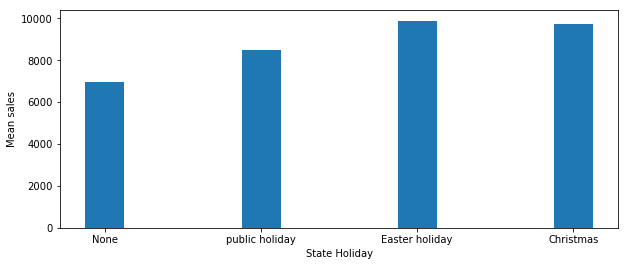

In [77]:
stateholiday_mean = df[df['Open'] == 1].groupby('StateHoliday').mean()['Sales']
print stateholiday_mean

plt.rcParams["figure.figsize"] = [10,4]
plt.bar(left = (0.2, 1.0, 1.8, 2.6),height = stateholiday_mean, width = 0.2, align="center")
plt.xticks((0.2, 1.0, 1.8, 2.6),('None','public holiday','Easter holiday','Christmas'))
plt.xlabel('State Holiday')
plt.ylabel('Mean sales')

通过上图可以看出复活节销量最高，圣诞节销量也比较高，非节假日销量低。

### 3.3 探索数据集的结论
- Sales特征的分布为正偏斜分布，均值为6956，中位数为6369，最大值为41551。
- Customer与Sales正相关，但是Customer不能直接使用，因为会造成信息泄露。
- 大部分门店的竞争对手都在1公里以内
- 大部分门店在周日休息
- 针对‘StoreType’特征，a类门店数目最多，有602个，b类门店数量最，少只有17个。b类门店平均每天的销售额最高，a，b，c类门店平均销售额几乎相同。
- 针对‘Assortment’特征，a类门店有593个，c类门店有513个，b类门店仅有9个，但b类门店平均每天的销售额最高。
- 各门店销售额随时间呈周期性变化，说明时间是预测销售额的重要的特征，需要构建新的时间特征，比如‘几号’，“第几周”，‘第几月’，‘第几年’等特征，预测集和训练集都有这样的特征，这样机器就可以根据时间特征进行预测了。
- 周日和周一销售额最高，周六销售额最低
- 月初、月末和月中的平均销售额会高些
- 第51周内每日平均销售额最高，圣诞节前一周，是购物黄金时期。
- 1月份，2月，9月是淡季，12月是销售旺季
- 每店每日的平均销售额逐年增加，但增加幅度不大，可能是通胀因素导致。
- 一年中销量最大的时间为第349天（12月15日），一年中销量最少的时间为第365天（12月31日），第121天(5月1日)的销量也较高
- 可以看出促销对门店的每日销售额影响显著，能提高38.76%
- 学校放假对门店的每日销售额影响不明显，仅能提高4.4%
- 复活节销量最高，圣诞节销量也比较高，非节假日销量低。


## 4 清理异常数据
为避免在测试集上产生信息泄露，所有异常值的清洗均在训练集上进行。
### 4.1 删除不合理数据
根据常识，关店时销售额等于0。首先看一下数据集是否符合上述常识。

In [78]:
# 列出关店时，销售额不等于0的数据点
df[(df['Open'] == 0) & (df['Sales'] != 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_Jan,PromoInterval_Feb,PromoInterval_Mar,PromoInterval_Apr,PromoInterval_May,PromoInterval_Jun,PromoInterval_Jul,PromoInterval_Aug,PromoInterval_Sept,PromoInterval_Oct,PromoInterval_Nov,PromoInterval_Dec,Test_set,DateDay,DateWeek,DateMonth,DateYear,DateDayOfYear


上述结果验证了,在数据集中，关店时销售额确实等于0。另外，我假设开店时，销售额应该大于0，如果开店一天都没有收入，属于极端情况。

In [79]:
df[(df['Open'] == 1) & (df['Sales'] == 0) & (df['Test_set'] == 0)].shape

(54, 35)

开店一天都没有收入的情况有54个数据点，在100万条数据点的情况下，将这54个数据点删除

In [80]:
# 删除开店，确没有收入的情况
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0) & (df['Test_set'] == 0))]

### 4.2 标记异常值 

In [81]:
# 按店统计异常值的总数量（只考虑开店情况）
outlier = []
for i in df['Store'].unique():
    array_temp = df[(df['Store'] == i) & (df['Test_set'] == 0)]['Sales']
    q75_temp, q25_temp = np.percentile(array_temp, [75 ,25])
    iqr_temp = q75_temp - q25_temp
    arry_1 = (array_temp > (1.5 * iqr_temp + q75_temp))
    outlier = outlier + list(arry_1[arry_1 == True].index)

In [82]:
df['Outlier'] = 0
df.loc[outlier, 'Outlier'] = 1
df[df['Outlier'] == 1].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_Jan,PromoInterval_Feb,PromoInterval_Mar,PromoInterval_Apr,PromoInterval_May,PromoInterval_Jun,PromoInterval_Jul,PromoInterval_Aug,PromoInterval_Sept,PromoInterval_Oct,PromoInterval_Nov,PromoInterval_Dec,Test_set,DateDay,DateWeek,DateMonth,DateYear,DateDayOfYear,Outlier
68099,85,7,2015-05-31,12040,1647,1,0,0,0,b,a,1870,10,2011,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,31,22,5,2015,151,1
68276,262,7,2015-05-31,32400,4668,1,0,0,0,b,a,1180,5,2013,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,31,22,5,2015,151,1
68288,274,7,2015-05-31,7479,1582,1,0,0,0,b,b,3640,-1,-1,1,10,2013,1,0,0,1,0,0,1,0,0,1,0,0,0,31,22,5,2015,151,1
68367,353,7,2015-05-31,9125,1951,1,0,0,0,b,b,900,-1,-1,1,14,2013,0,1,0,0,1,0,0,1,0,0,1,0,0,31,22,5,2015,151,1
68526,512,7,2015-05-31,8285,1500,1,0,0,0,b,b,590,-1,-1,1,5,2013,0,0,1,0,0,1,0,0,1,0,0,1,0,31,22,5,2015,151,1


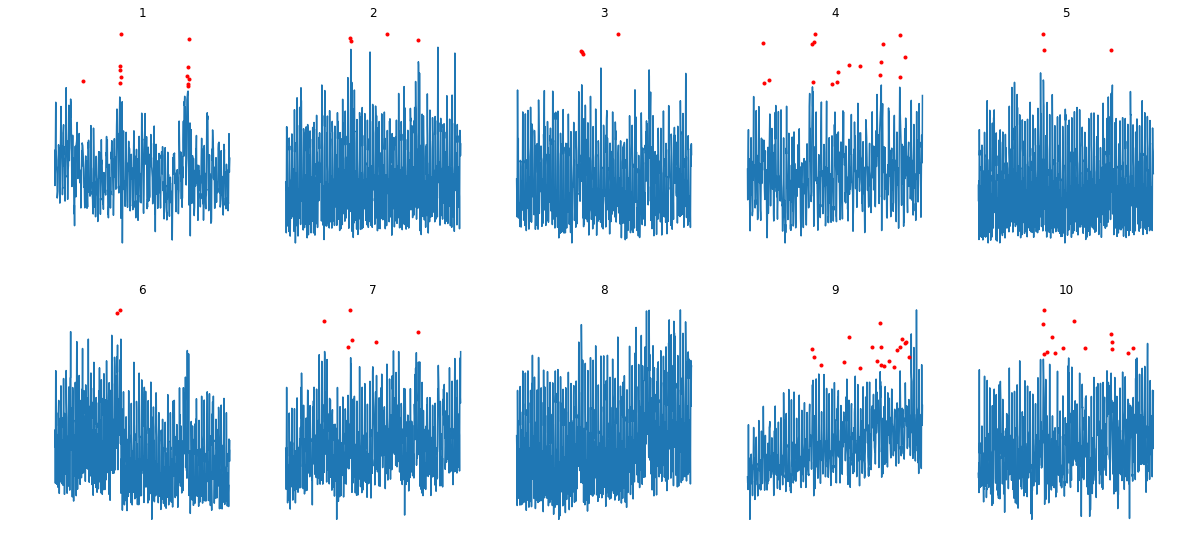

In [83]:
# 画出编号1~10门店的异常值
no_stores_to_check = 10

plt.rcParams["figure.figsize"] = [20,no_stores_to_check*5]

for i in range(1,no_stores_to_check+1):
    stor = i
    
    X1 = df.loc[(df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == 0)]
    y1 = df.loc[(df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == 0)]['Sales']

    # Outliers
    X2 = df.loc[(df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == 1)]
    y2 = df.loc[(df['Store'] == stor) & (df['Open'] == 1) & (df['Outlier'] == 1)]['Sales']
   
    plt.subplot(10,5,i)
    plt.plot(X1['Date'], y1, '-')
    plt.plot(X2['Date'], y2, 'r.')
    plt.title(i)
    plt.axis('off')

上图红点位置为异常值。

## 5 特征工程

### 5.1 构建新的特征
在最近一个季度上（2015-03-01至2015-05-31），计算如下几个新的特征（这些特征的值赋予所有样本）：   
- 'SalesPerDay'： 最近一季度的单店每日销售额平均值  
- 'CustomersPerDay'：最近一季度单店每日客流量平均值  
- 'SalesPerCustomersPerDay'：最近一季度单店每日每人平均消费额  
- 'SalesPerWeekDay'：最近一季度单店“周一到周日分别统计”的每日销售额平均值，即基准模型的参数。 

In [84]:
# 构建最近一季度的数据集
df_season = df[(pd.to_datetime('2015-03-01') <= df['Date'])& (df['Date'] <= pd.to_datetime('2015-05-31')) ]
# 计算最近一季度内单店销售额总和
store_data_sales = df_season.groupby('Store')['Sales'].sum()
# 计算最近一季度单店客流量总和
store_data_customers = df_season.groupby('Store')['Customers'].sum()
# 计算最近一季度内单店的开店天数
store_data_open = df_season.groupby('Store')['Open'].sum()

In [85]:
# 计算最近一季度，单点每日销售额平均值
store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

df = pd.merge(df, store_data_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
df = pd.merge(df, store_data_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
df = pd.merge(df, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])

In [86]:
# 计算最近一季度每店周一到周日的平均营业额
store_sales_per_week_day = df_season.groupby(['Store','DayOfWeek'])['Sales'].sum()/(df_season.groupby(['Store','DayOfWeek'])['Open'].sum())
store_sales_per_week_day = store_sales_per_week_day.fillna(0)
df = pd.merge(df, store_sales_per_week_day.reset_index(name='SalesPerWeekDay'), how='left', on=['Store','DayOfWeek'])

### 5.2 对数特征缩放

In [87]:
# 构造log（Sales）
df['SalesLog'] = np.log1p(df['Sales']) # = np.log(df['Sales'] + 1)

# 对'CompetitionDistance'，'SalesPerDay'和'SalesPerWeekDay'进行对数缩放
df['CompetitionDistanceLog'] = np.log(df['CompetitionDistance'])
df['SalesPerDayLog'] = np.log(df['SalesPerDay']) 
df['SalesPerWeekDayLog'] = np.log1p(df['SalesPerWeekDay'])

### 5.3 独热编码
分类特征需要用独热编码表示

In [88]:
# 独热编码转换
df = pd.get_dummies(df)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_Jan,PromoInterval_Feb,PromoInterval_Mar,PromoInterval_Apr,PromoInterval_May,PromoInterval_Jun,PromoInterval_Jul,PromoInterval_Aug,PromoInterval_Sept,PromoInterval_Oct,PromoInterval_Nov,PromoInterval_Dec,Test_set,DateDay,DateWeek,DateMonth,DateYear,DateDayOfYear,Outlier,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay,SalesPerWeekDay,SalesLog,CompetitionDistanceLog,SalesPerDayLog,SalesPerWeekDayLog,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,5,2015-07-31,5263,555,1,1,1,1270,9,2008,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,31,31,7,2015,212,0,4586.191781,533.342466,8.598962,4238.636364,8.568646,7.146772,8.430805,8.352233,1,0,0,0,0,0,1,0,1,0,0
1,2,5,2015-07-31,6064,625,1,1,1,570,11,2007,1,13,2010,1,0,0,1,0,0,1,0,0,1,0,0,1,31,31,7,2015,212,0,5083.849315,583.191781,8.717286,4490.363636,8.710290,6.345636,8.533824,8.409912,1,0,0,0,1,0,0,0,1,0,0
2,3,5,2015-07-31,8314,821,1,1,1,14130,12,2006,1,14,2011,1,0,0,1,0,0,1,0,0,1,0,0,1,31,31,7,2015,212,0,7017.287671,739.369863,9.490903,6990.636364,9.025816,9.556055,8.856132,8.852470,1,0,0,0,1,0,0,0,1,0,0
3,4,5,2015-07-31,13995,1498,1,1,1,620,9,2009,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,31,31,7,2015,212,0,10008.493151,1341.109589,7.462845,9276.636364,9.546527,6.429719,9.211189,9.135362,1,0,0,0,0,0,1,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,1,29910,4,2015,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,31,31,7,2015,212,0,4709.397260,537.945205,8.754418,4693.454545,8.481151,10.305948,8.457315,8.454137,1,0,0,0,1,0,0,0,1,0,0


### 5.4 特征选择

In [89]:
# 初始特征
features_raw = ['Store','DayOfWeek', 'Open', 'Promo', 'SchoolHoliday',
                'CompetitionDistanceLog','CompetitionOpenSinceMonth',
                'CompetitionOpenSinceYear','Promo2','Promo2SinceWeek',
                'Promo2SinceYear','PromoInterval_Jan', 'PromoInterval_Feb',
                'PromoInterval_Mar', 'PromoInterval_Apr', 'PromoInterval_May',
                'PromoInterval_Jun', 'PromoInterval_Jul', 'PromoInterval_Aug',
                'PromoInterval_Sept', 'PromoInterval_Oct', 'PromoInterval_Nov',
                'PromoInterval_Dec','DateDay', 'DateWeek',
                'DateMonth', 'DateYear', 'DateDayOfYear',
                'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
                'StateHoliday_c', 'StoreType_a', 'StoreType_b', 'StoreType_c',
                'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c',
                'SalesPerDayLog','CustomersPerDay','SalesPerCustomersPerDay','SalesPerWeekDayLog']

features_y ='SalesLog'

In [90]:
# 初始特征个数
len(features_raw)

43

In [91]:
# 在训练集上筛选特征
features_train = df[(df['Test_set'] == 0) & (df['Outlier'] == 0)][features_raw]
labels_train = df[(df['Test_set'] == 0) & (df['Outlier'] == 0)][features_y]

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
selector = SelectKBest(score_func=f_regression, k=10)
features_new = selector.fit_transform(features_train, labels_train)

In [92]:
feature_score ={}
for i in range(len(features_raw)):
    feature_score[features_raw[i]] = round(selector.scores_[i],2)
print 'Feature_score is below:'
sorted(feature_score.iteritems(),key=lambda asd:asd[1],reverse = True)

Feature_score is below:


[('Open', 71204986.43),
 ('SalesPerWeekDayLog', 3188345.23),
 ('DayOfWeek', 384413.54),
 ('StateHoliday_0', 161569.19),
 ('Promo', 118761.4),
 ('StateHoliday_a', 95749.55),
 ('StateHoliday_b', 31128.45),
 ('StateHoliday_c', 18856.76),
 ('CustomersPerDay', 7207.02),
 ('SalesPerDayLog', 7052.49),
 ('SchoolHoliday', 6259.0),
 ('StoreType_b', 3772.71),
 ('Assortment_b', 1767.43),
 ('DateDay', 723.11),
 ('Promo2SinceYear', 381.98),
 ('Promo2', 381.91),
 ('Assortment_a', 292.5),
 ('SalesPerCustomersPerDay', 191.15),
 ('Promo2SinceWeek', 127.89),
 ('PromoInterval_Sept', 96.6),
 ('PromoInterval_Jun', 96.6),
 ('PromoInterval_Dec', 96.6),
 ('PromoInterval_Mar', 96.6),
 ('Assortment_c', 93.0),
 ('PromoInterval_Jan', 81.02),
 ('PromoInterval_Apr', 81.02),
 ('PromoInterval_Jul', 81.02),
 ('PromoInterval_Oct', 81.02),
 ('PromoInterval_Nov', 76.17),
 ('PromoInterval_May', 76.17),
 ('PromoInterval_Feb', 76.17),
 ('PromoInterval_Aug', 76.17),
 ('StoreType_a', 47.62),
 ('CompetitionDistanceLog', 40.33),

In [93]:
# 选出得分超过100分的特征
features_x = []
for feature in feature_score:
    if feature_score[feature] >100:
        features_x.append(feature)
features_x

['Promo2SinceYear',
 'DayOfWeek',
 'Promo',
 'DateDay',
 'SchoolHoliday',
 'StateHoliday_0',
 'Assortment_a',
 'StateHoliday_b',
 'Assortment_b',
 'SalesPerDayLog',
 'Promo2SinceWeek',
 'SalesPerWeekDayLog',
 'CustomersPerDay',
 'StoreType_b',
 'StateHoliday_c',
 'StateHoliday_a',
 'Promo2',
 'Open',
 'SalesPerCustomersPerDay']

In [94]:
len(features_x)

19

## 6. 评估标准
kaggle官方网站给出的评估标准是“均方根百分比误差”rmspe，下面是计算rmspe的程序。其中y测试集的目标值（pd.Series类型），yhat是预测值（np.array类型）

In [95]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    y = y.values
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

## 7. 基准模型的构建
取测试集前3个月内“每店周一到周日各自的销售额”的均值建立基准模型，实际是取'SalesPerWeekDay'特征作为基准模型。

In [96]:
# 测试集上基准模型的预测值
y_base = df[df['Test_set'] == 1]['SalesPerWeekDay']

# 实际值
y_test = df[df['Test_set'] == 1]['Sales']

In [97]:
rmspe(y_base, y_test)

0.21872648303178988

基准模型的rmspe为0.2187

## 8 建立模型

### 8.1 模型选择
选择3种模型：决策树回归模型、GBDT梯度提升树回归模型和随机森林回归模型

In [98]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn import ensemble

In [99]:
# 建立测试集和训练集
# 训练集不含异常值的情况
X_train = df[(df['Test_set'] == 0) & (df['Outlier'] == 0)][features_x]
y_train = df[(df['Test_set'] == 0) & (df['Outlier'] == 0)][features_y]

# y_train_label是在训练集上的没有经过对数转换的销售额
y_train_label = df[(df['Test_set'] == 0) & (df['Outlier'] == 0)]['Sales']

# 训练集含异常值的情况
# X_train = df[(df['Test_set'] == 0)][features_x]
# y_train = df[(df['Test_set'] == 0)][features_y]
# y_train_label = df[(df['Test_set'] == 0)]['Sales']

# 测试集
X_test = df[df['Test_set'] == 1][features_x]
y_test = df[df['Test_set'] == 1]['Sales']

### 8.1.1 决策树回归

In [100]:
# 建议统一的机器学习模型的验证流程
def train_predict(learner, X_train, y_train, X_test, y_test, y_train_label): 

    start = time.clock()    
    learner = learner.fit(X_train,y_train)
    
    # 计算模型在test_set的分数
    yhat_test = learner.predict(X_test)
    yhat_test = np.exp(yhat_test)-1
    rmspe_score_on_testset = rmspe(yhat_test, y_test)
    
    # 计算模型在train_set的分数
    yhat_train = learner.predict(X_train)
    yhat_train = np.exp(yhat_train) - 1
    rmspe_score_on_trainset = rmspe(yhat_train, y_train_label)
    
    print "{} rmspe score on test set: {}".format(learner.__class__.__name__, rmspe_score_on_testset)
    print "{} rmspe score on train set: {}".format(learner.__class__.__name__, rmspe_score_on_trainset)
    end = time.clock()
    print "spend: %f s" % (end - start)
    return learner

In [101]:
tree = DecisionTreeRegressor(random_state=42)
tree = train_predict(tree, X_train, y_train, X_test, y_test, y_train_label)

DecisionTreeRegressor rmspe score on test set: 0.158780792511
DecisionTreeRegressor rmspe score on train set: 0.100828705692
spend: 10.678957 s


默认参数下，决策树回归模型在测试集上rmspe得分为0.1588，在训练集上的rmspe得分为0.1008，有过拟合的现象。

### 8.1.2 GBDT梯度提升决策树回归模型

In [102]:
gbrt = ensemble.GradientBoostingRegressor(random_state = 42)
gbrt = train_predict(gbrt, X_train, y_train, X_test, y_test, y_train_label)

GradientBoostingRegressor rmspe score on test set: 0.124950507244
GradientBoostingRegressor rmspe score on train set: 0.21676759266
spend: 215.006197 s


默认参数下，GBDT回归模型在测试集上rmspe得分为0.1250，在训练集上的rmspe得分为0.2168，在训练集上有欠拟合的现象，而且计算时间较长。

### 8.1.3 随机森林回归

In [103]:
rf = ensemble.RandomForestRegressor(random_state = 42)
rf = train_predict(rf, X_train, y_train, X_test, y_test, y_train_label)

RandomForestRegressor rmspe score on test set: 0.143760225655
RandomForestRegressor rmspe score on train set: 0.114796749714
spend: 68.361174 s


随机森林回归综合表现最好，选择随机森林作为最终的模型。

### 8.2 调参
采用在训练集上进行交叉检验配合网格搜索来确定“随机森林模型”的最大深度。

In [104]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # score分数越大越好
    score = 1 / rmspe(y_predict, y_true)
    return score

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """

    cv_sets = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 42)

    regressor = ensemble.RandomForestRegressor()

    params = {'max_depth':range(14,19)}

    scoring_fnc = make_scorer(performance_metric)

    grid = GridSearchCV(regressor, params,scoring = scoring_fnc,cv = cv_sets) 

    grid = grid.fit(X, y)
    
    return grid.best_estimator_

In [105]:
# 计算最大深度
# start = time.clock()
# reg = fit_model(X_train, y_train)
# print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])
# end = time.clock()
# print "spend: %f s" % (end - start)

注：查找最优的最大深度时间较长，需要20分钟左右的时间，为了节约计算时间，我将上面的程序注释掉。最终最优的"最大深度"为18。下面对n_estimators进行调参。

In [106]:
# 取n_estimators分别为10,20,30,40
for n in [10,20,30,40]:
    rf =ensemble.RandomForestRegressor(random_state = 42, max_depth=18, n_estimators=n)
    print 'n_estimators = {}'.format(n)    
    learner = train_predict(rf, X_train, y_train, X_test, y_test, y_train_label)
    print '---------------------------------------------------------------'

n_estimators = 10
RandomForestRegressor rmspe score on test set: 0.127657940667
RandomForestRegressor rmspe score on train set: 0.14009207935
spend: 52.584728 s
--------------------------------------------------------------------
n_estimators = 20
RandomForestRegressor rmspe score on test set: 0.127068748931
RandomForestRegressor rmspe score on train set: 0.137569279516
spend: 104.181395 s
--------------------------------------------------------------------
n_estimators = 30
RandomForestRegressor rmspe score on test set: 0.126751773936
RandomForestRegressor rmspe score on train set: 0.132697289947
spend: 156.083677 s
--------------------------------------------------------------------
n_estimators = 40
RandomForestRegressor rmspe score on test set: 0.126609379037
RandomForestRegressor rmspe score on train set: 0.13252944435
spend: 208.913925 s
--------------------------------------------------------------------


可以看到随着n_estimarots的增加，模型在测试集上的表现越来越好，但是收敛得越来越慢，而且所需要的计算时长也相应增加，综合考虑取n_estimator=40，即不再增加n_estimators的数量。最终模型在测试集上的rmspe的分为0.1266

## 9 模型验证
### 9.1 结果可视化

In [107]:
yhat_test = learner.predict(X_test)
yhat_test = np.exp(yhat_test)-1

In [108]:
# 复制测试集并添加新的列
df_plot = df.loc[df['Test_set'] == 1].copy()
df_plot['Predict'] = yhat_test

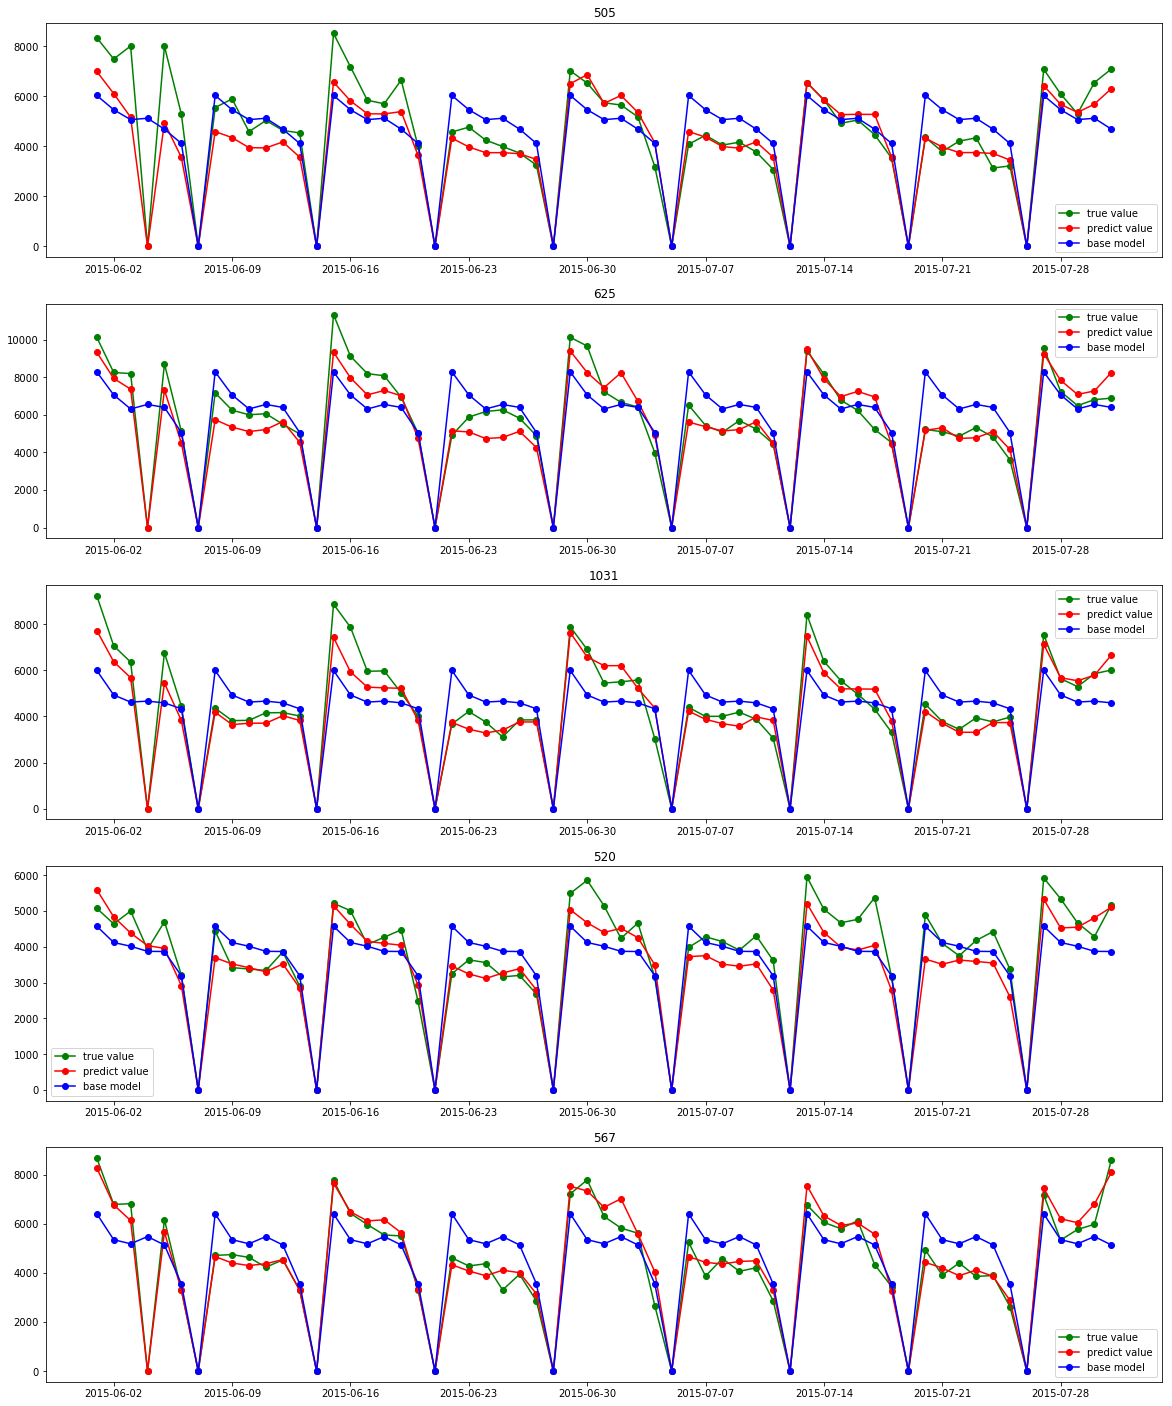

In [109]:
# 随机取5个门店
random.seed(11)
list_stores_to_check = random.sample(df_plot['Store'].unique(),5)

#设置画图板尺寸
plt.rcParams["figure.figsize"] = [20,len(list_stores_to_check)*5]

j = 1

for i in list_stores_to_check:
    # Normal sales
    plt.subplot(len(list_stores_to_check),1,j)
    x_time = df_plot.loc[(df_plot['Store'] == i)]['Date']
    # 真实值
    y_true = df_plot.loc[(df_plot['Store'] == i)]['Sales']
    # 随机森林模型预测值
    y_predict = df_plot.loc[(df_plot['Store'] == i)]['Predict']
    # 
    y_basemodel = df_plot.loc[(df_plot['Store'] == i)]['SalesPerWeekDay']
    
    plt.plot(x_time, y_true,'go-',label='true value')
    plt.plot(x_time, y_predict,'ro-',label='predict value')
    plt.plot(x_time, y_basemodel,'bo-',label='base model')
    plt.legend()
    plt.title(i)
    j += 1

通过上图可知，随机森林模型能较好地预测出各店未来的销售额。

### 9.2 独立样本T检验

可以拿“基准模型百分比误差” 与 “随机森林模型的百分比误差”进行独立样本T检验   
零假设：基准模型百分比误差均值 = 随机森林模型的百分比误差均值  
对立假设：基准模型百分比误差均值 != 随机森林模型的百分比误差均值   

In [110]:
from scipy.stats import ttest_ind
df_T = df_plot[df_plot['Open']==1]
base_error = (df_T['Sales'] - df_T['SalesPerWeekDay'])/df_T['Sales']
predict_error = (df_T['Sales'] - df_T['Predict'])/df_T['Sales']

In [111]:
ttest_ind(base_error, predict_error)

Ttest_indResult(statistic=-69.201618825720871, pvalue=0.0)

p_value等于0,拒绝零假设，即二者的预测的百分比误差不一致。

## 10. 结论


该模型在调整参数后，选择了最大深度18,40棵树，即用40棵树预测的平均值作为最终的预测值。选择的参数简单易懂。

计算结果为0.1266，计算时长约为200s，预测的结果超过了基准模型,并且可排进kaggle参赛选手前50%（kaggle比赛"private board"的中位数为0.12968）。
